In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib as mpl; import matplotlib.pyplot as plt; from matplotlib import cm
from datetime import datetime

matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

# Add this to python2 code to make life easier
from __future__ import absolute_import, division, print_function

## Read the JSON data:

In [2]:
df = pd.read_json('data_exercise.json') #Read it as a pandas dataframe

In [3]:
print(df.shape)
df.head()

(4823567, 5)


,date,isFirst,timestamp,uid,utmSource
0,2016-02-29,False,2016-02-29 08:00:01.255,g4Hjpoji4dmv,Biznesowe+Rewolucje
1,2016-02-29,False,2016-02-29 08:00:01.556,g4Hjpoji4dmv,Biznesowe+Rewolucje
2,2016-02-29,False,2016-02-29 08:00:01.770,75121338,program
3,2016-02-29,False,2016-02-29 08:00:03.129,11l0tD2wFPFO,None
4,2016-02-29,False,2016-02-29 08:00:03.610,56429432,None


The data has 4,823,567 rows and 5 columns:<br>
•	date: date of the ping (Pacific time)<br>
•	timestamp: ping timestamp <br>
•	uid: unique id assigned to users (if the string is purely numeric, this means the user is registered, otherwise it's a device id) <br>
•	isFirst: true if this is the user's first ping ever (some users have been using the app before February) <br>
•	utmSource: traffic source from which the user came <br>

## Exploratory Analysis

In [4]:
## Exploration of the data
import pandas_profiling

pandas_profiling.ProfileReport(df)

/Applications/Anaconda-/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Number of variables,5
Number of observations,4823567
Total Missing (%),6.9%
Total size in memory,188.6 MiB
Average record size in memory,41.0 B
Numeric,1
Categorical,2
Date,2
Text (Unique),0
Rejected,0
Distinct count,29


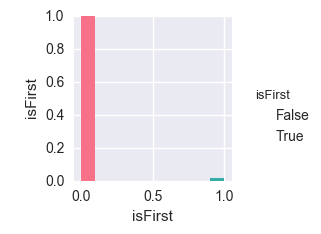

In [5]:
import seaborn as sns
sns.set()
sns.set_style("darkgrid")

plt.rcParams['figure.figsize'] = (20, 12)
sns.pairplot(df, palette="husl", hue="isFirst", markers=["o", "s"])
plt.show()

In [6]:
df.describe()

,date,isFirst,timestamp,uid,utmSource
count,4823567,4823567,4823567,4823567,3149181
unique,29,2,4802369,246840,52
top,2016-02-29 00:00:00,False,2016-02-25 19:46:44.202000,vwLJO2uDWrXr,Biznesowe+Rewolucje
freq,194747,4736834,18,2853,1780384
first,2016-02-01 00:00:00,NaN,2016-02-01 08:00:01.230000,NaN,NaN
last,2016-02-29 00:00:00,NaN,2016-03-01 07:59:58.557000,NaN,NaN


In [7]:
df.tail()

,date,isFirst,timestamp,uid,utmSource
4823562,2016-02-06,False,2016-02-07 07:59:55.890,QLECxJO2VaIZ,Biznesowe+Rewolucje
4823563,2016-02-06,False,2016-02-07 07:59:57.185,58056634,shmoop_left
4823564,2016-02-06,False,2016-02-07 07:59:57.629,56936469,None
4823565,2016-02-06,False,2016-02-07 07:59:59.555,63953998,Biznesowe+Rewolucje
4823566,2016-02-06,False,2016-02-07 07:59:59.555,63953998,Biznesowe+Rewolucje


In [8]:
print('There are', len(df), 'entries, from which', len(df.drop_duplicates()), 'are unique')

There are 4823567 entries, from which 4810588 are unique


There are 0.3% duplicated entries, which I will discard:

In [9]:
df_s = df.drop_duplicates()

In [10]:
print(1-len(df_s.utmSource.dropna())/len(df_s.utmSource), '% of the utmSource values are missing data')

0.3467771507350037 % of the utmSource values are missing data


## Q1: Show the daily active users over the month, including all users. A user is considered active if they pinged at least once on a given day.

A user is considered active if he/she pings at least once a day, meaning that he will have at least one timestamp entry. In order to calculate how many active users there are per day, I will group the dataset by date and will count the unique "uids". 

In [11]:
total_users = df_s.uid.unique()
df_grp_date = df_s.groupby(['date'])
active_users = df_grp_date.uid.nunique().reset_index()
active_users.head()

,date,uid
0,2016-02-01,112504
1,2016-02-02,112317
2,2016-02-03,113062
3,2016-02-04,111098
4,2016-02-05,102420


In [12]:
print('From the', len(total_users), 'users,', active_users.uid[0], 'are active on', active_users.date[0])

From the 246840 users, 112504 are active on 2016-02-01 00:00:00


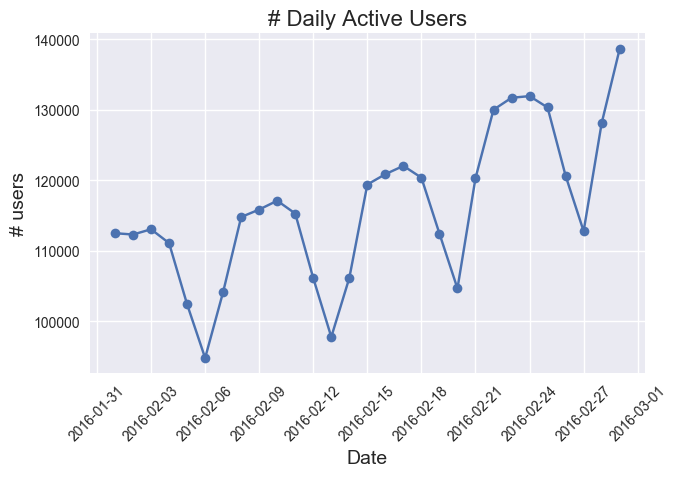

In [13]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(1,1, figsize=(7,5))
mpl.rcParams['font.size'] = 14.; mpl.rc('xtick', labelsize=12); mpl.rc('ytick', labelsize=12) 

plt.plot_date(active_users.date, active_users.uid, 'o-')
plt.xlabel('Date', fontsize=14); plt.ylabel('# users', fontsize=14); plt.title('# Daily Active Users', fontsize=16)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
plt.tight_layout()
plt.show(fig)
#plt.savefig('./figs/daily_active_users.png', bbox_inches='tight')

plt.close('all')

At first sight, the number of daily users shows an increasing trend with a weekly periodicity: the number of users slightly decreases already on Thursday, having a minimum on Saturday and increasing again already on Sunday.

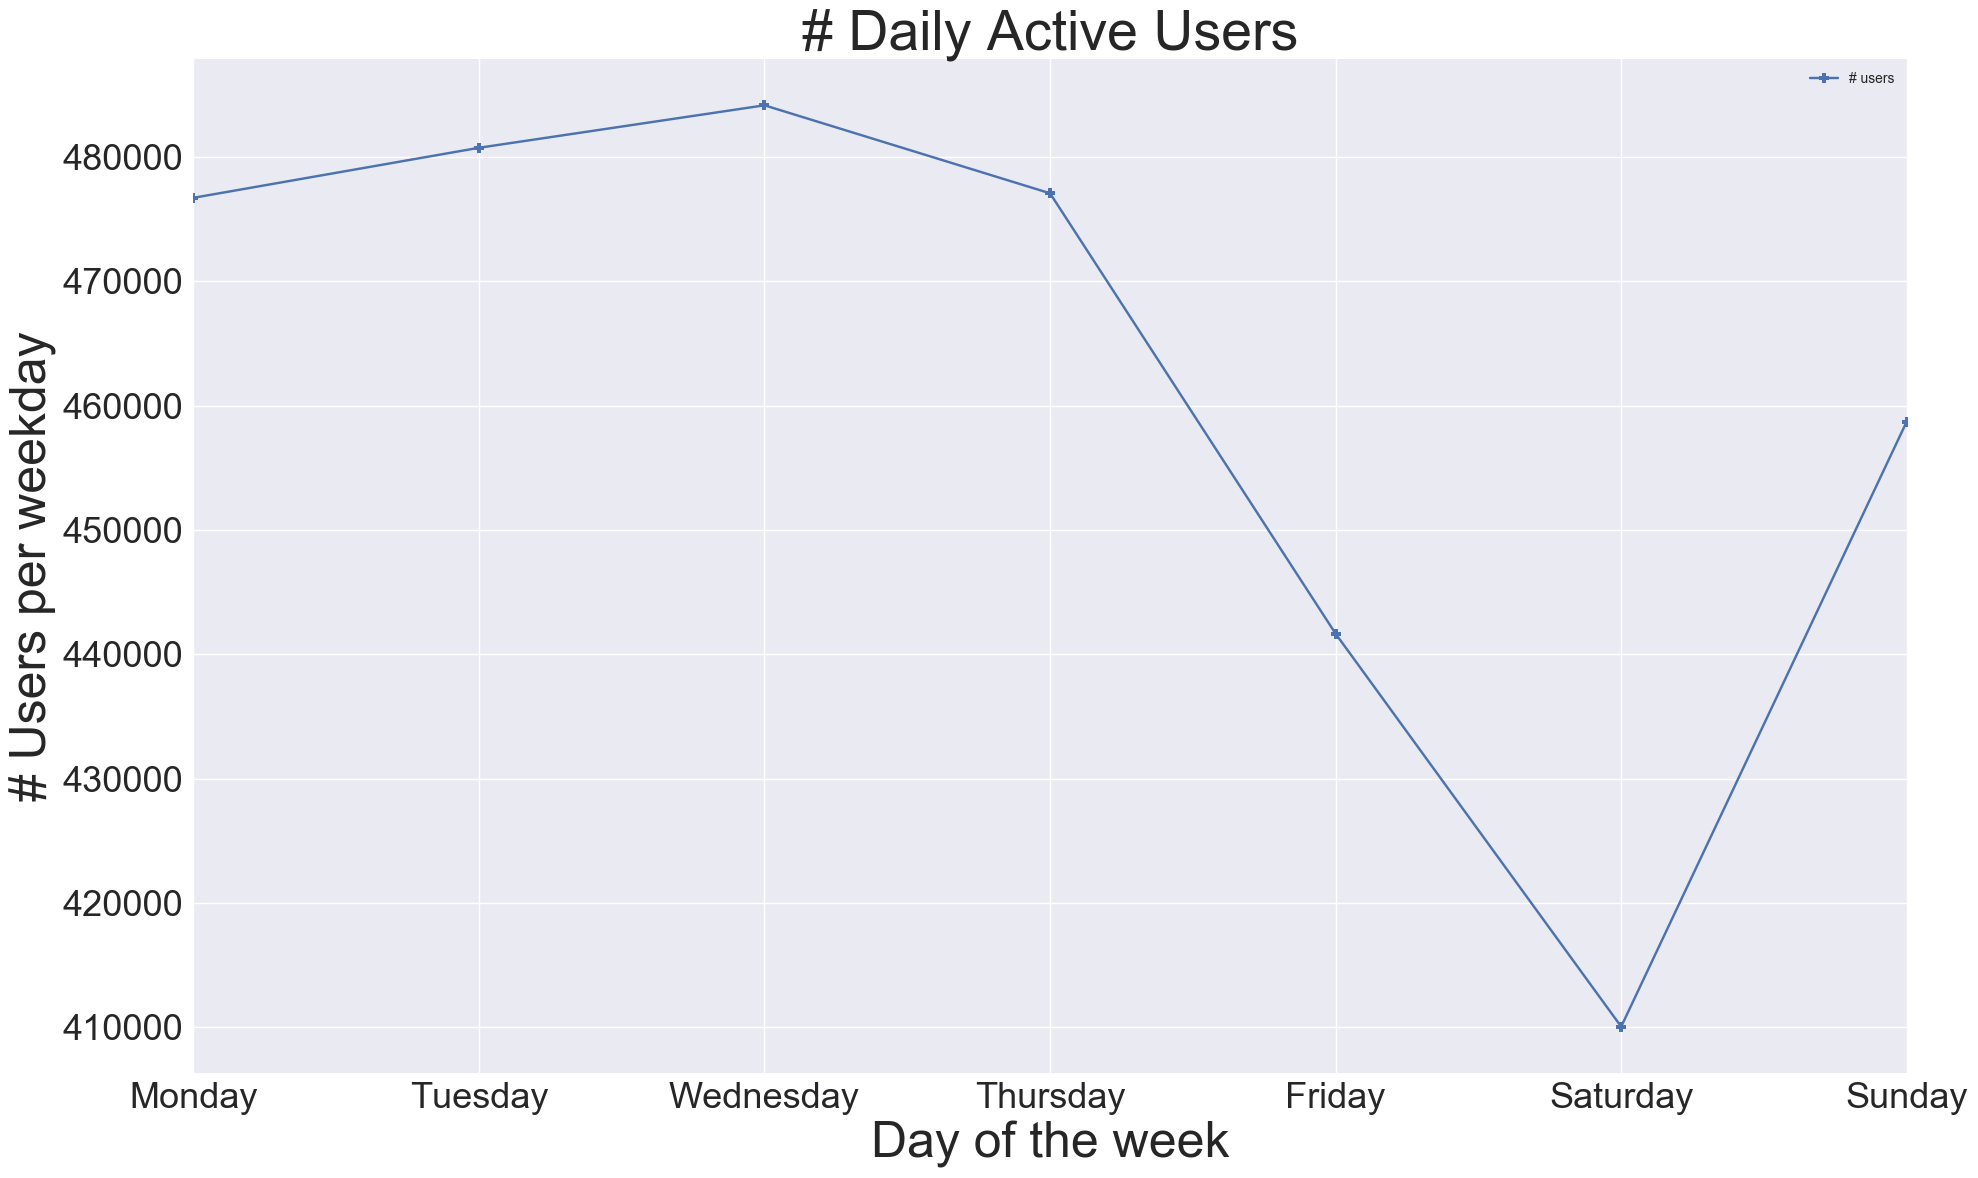

In [14]:
active_users['dow'] = active_users['date'].apply(lambda x: x.weekday())
week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday',  5: 'Saturday', 6: 'Sunday'}

active_users_dow = active_users[0:-1].groupby('dow').sum().reset_index()
active_users_dow['dow'] = active_users_dow['dow'].apply(lambda x: week[x])
active_users_dow['uid_avg'] = active_users_dow['uid']/active_users.dow.value_counts()

fig = plt.figure(figsize=(6,4))
#plt.plot(active_users_dow.uid)
active_users_dow.plot(x="dow", y="uid", fontsize=26, marker='P', label='# users')
plt.xlabel('Day of the week', fontsize=36); plt.ylabel('# Users per weekday', fontsize=36)
plt.title('# Daily Active Users', fontsize=40)
plt.tight_layout()
plt.show(fig)
#plt.savefig('./figs/active_users_weekday.png', bbox_inches='tight')

plt.close()

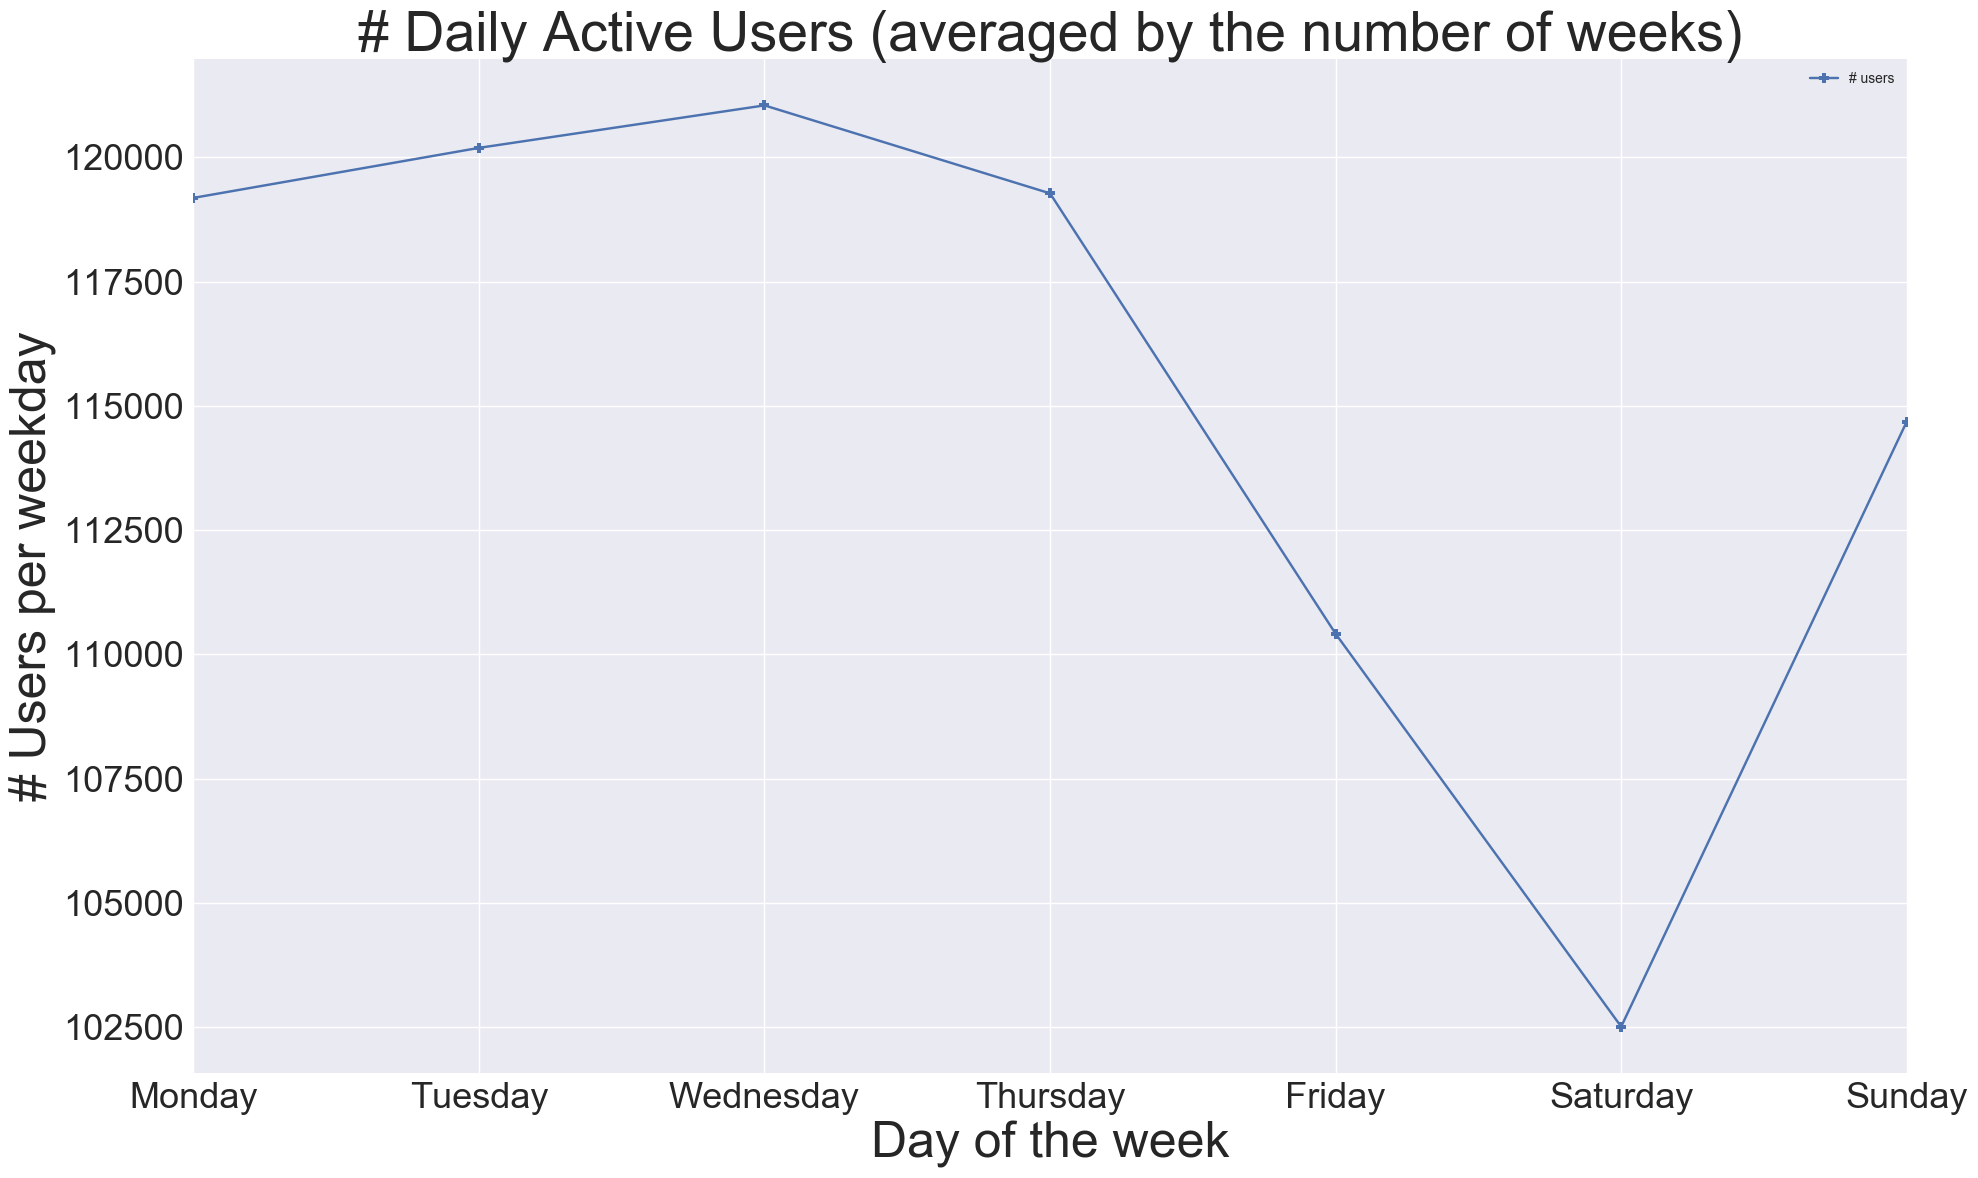

In [15]:
active_users['dow'] = active_users['date'].apply(lambda x: x.weekday())
week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday',  5: 'Saturday', 6: 'Sunday'}

active_users_dow = active_users[0:-1].groupby('dow').sum().reset_index()
active_users_dow['dow'] = active_users_dow['dow'].apply(lambda x: week[x])
active_users_dow['uid_avg'] = active_users_dow['uid']/active_users[0:-1].dow.value_counts()

fig = plt.figure(figsize=(6,4))
#plt.plot(active_users_dow.uid)
active_users_dow.plot(x="dow", y="uid_avg", fontsize=26, marker='P', label='# users')
plt.xlabel('Day of the week', fontsize=36); plt.ylabel('# Users per weekday', fontsize=36)
plt.title('# Daily Active Users (averaged by the number of weeks)', fontsize=40)
plt.tight_layout()
plt.show(fig)
#plt.savefig('./figs/active_users_weekday_avg.png', bbox_inches='tight')

plt.close()

The number of users peaks on Wednesday. It decreases along the week, until Saturday and on Sunday it starts to increase again.

## Q2: Calculate the daily retention curve for users who used the app for the first time on the following dates: Feb 4th, Feb 10th, and Feb 14th. Also, show the number of users from each cohort.

Daily retention curve is defined as the % of users from the cohort, who used the product that day.

I will select the users on Feb 4, Feb 10, and Feb 14, 2016. <br>

In [16]:
df_04 = df_s[(df_s.date == '2016-02-04') & (df_s.isFirst == True)].reset_index()
print('There are',len(df_04.uid), 'new users on', df_04.date.loc[0])
users_04 = df_04.uid.tolist()
df_04.uid.head()

There are 2735 new users on 2016-02-04 00:00:00


0    60973978
1    68340787
2    68741878
3    52853923
4    54756610
Name: uid, dtype: object

In [17]:
df_s.sort_index(by='date', ascending=True, inplace=True)
dates = df_s.date.unique()
print('There are', len(dates), 'different dates')
returned_user_04 = {}
dates_04 = []
for i in range(len(dates)):
#for i in range(4,7):
    df_date = df_s[df_s.date == dates[i]]
    df_date.sort_index(by='date', ascending=False, inplace=True)
    if df_date.date.iloc[0] >= df_04.date.iloc[0]:
        #print(df_date.date.iloc[0], 'is a later date than', df_04.date.iloc[0])
        #day = df_date.date.iloc[0].day ; dates_04.append(df_date.date.iloc[0])
        n_users = len(df_date[df_date['uid'].isin(users_04)]['uid'].unique())
        returned_user_04[df_date.date.iloc[0]] = n_users

print('From the', len(users_04), returned_user_04, 'return each day')

/Applications/Anaconda-/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  """Entry point for launching an IPython kernel.
/Applications/Anaconda-/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inplace=inplace)
/Applications/Anaconda-/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  if __name__ == '__main__':


There are 29 different dates
From the 2735 {Timestamp('2016-02-04 00:00:00'): 2735, Timestamp('2016-02-05 00:00:00'): 1490, Timestamp('2016-02-06 00:00:00'): 1202, Timestamp('2016-02-07 00:00:00'): 1266, Timestamp('2016-02-08 00:00:00'): 1313, Timestamp('2016-02-09 00:00:00'): 1206, Timestamp('2016-02-10 00:00:00'): 1197, Timestamp('2016-02-11 00:00:00'): 1184, Timestamp('2016-02-12 00:00:00'): 1017, Timestamp('2016-02-13 00:00:00'): 920, Timestamp('2016-02-14 00:00:00'): 971, Timestamp('2016-02-15 00:00:00'): 1077, Timestamp('2016-02-16 00:00:00'): 1074, Timestamp('2016-02-17 00:00:00'): 1071, Timestamp('2016-02-18 00:00:00'): 1052, Timestamp('2016-02-19 00:00:00'): 956, Timestamp('2016-02-20 00:00:00'): 864, Timestamp('2016-02-21 00:00:00'): 1002, Timestamp('2016-02-22 00:00:00'): 1053, Timestamp('2016-02-23 00:00:00'): 1043, Timestamp('2016-02-24 00:00:00'): 1049, Timestamp('2016-02-25 00:00:00'): 1024, Timestamp('2016-02-26 00:00:00'): 905, Timestamp('2016-02-27 00:00:00'): 829, Ti

In [18]:
returned_user_04_norm = {}
for key, value in returned_user_04.items():
    returned_user_04_norm[key] = value / len(users_04)

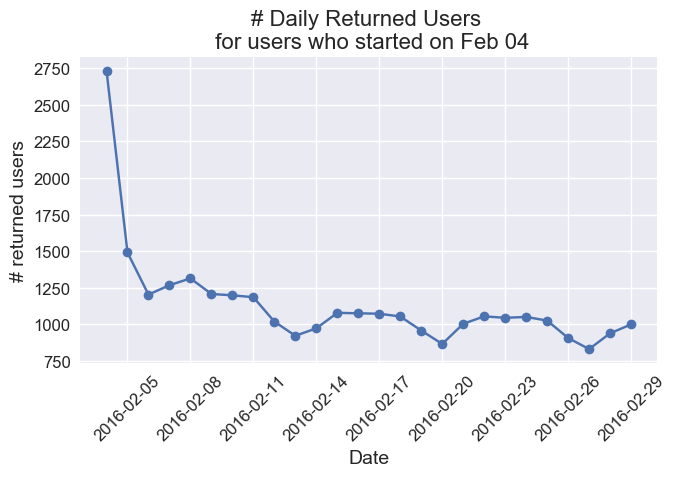

In [19]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
mpl.rcParams['font.size'] = 14.; mpl.rc('xtick', labelsize=12); mpl.rc('ytick', labelsize=12) 

plt.plot_date(*zip(*sorted(returned_user_04.items())), 'o-')
plt.xlabel('Date', fontsize=14); plt.ylabel('# returned users', fontsize=14)
plt.title('# Daily Returned Users \n for users who started on Feb 04', fontsize=16)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
   
plt.tight_layout()
plt.show()

In [20]:
df_10 = df_s[(df_s.date == '2016-02-10') & (df_s.isFirst == True)].reset_index()
print('There are',len(df_10.uid), 'new users on', df_10.date.loc[0])
users_10 = df_10.uid.tolist()

There are 3131 new users on 2016-02-10 00:00:00


In [21]:
returned_user_10 = {}
for i in range(len(dates)):
    df_date = df_s[df_s.date == dates[i]]
    df_date.sort_index(by='date', ascending=False, inplace=True)
    if df_date.date.iloc[0] >= df_10.date.iloc[0]:
        #print(df_date.date.iloc[0], 'is a later date than', df_10.date.iloc[0])
        n_users = len(df_date[df_date['uid'].isin(users_10)]['uid'].unique())
        returned_user_10[df_date.date.iloc[0]] = n_users

print('From the', len(users_10), returned_user_10, 'return each day')

/Applications/Anaconda-/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  after removing the cwd from sys.path.
/Applications/Anaconda-/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inplace=inplace)


From the 3131 {Timestamp('2016-02-10 00:00:00'): 3129, Timestamp('2016-02-11 00:00:00'): 1895, Timestamp('2016-02-12 00:00:00'): 1586, Timestamp('2016-02-13 00:00:00'): 1368, Timestamp('2016-02-14 00:00:00'): 1451, Timestamp('2016-02-15 00:00:00'): 1547, Timestamp('2016-02-16 00:00:00'): 1526, Timestamp('2016-02-17 00:00:00'): 1512, Timestamp('2016-02-18 00:00:00'): 1415, Timestamp('2016-02-19 00:00:00'): 1310, Timestamp('2016-02-20 00:00:00'): 1202, Timestamp('2016-02-21 00:00:00'): 1321, Timestamp('2016-02-22 00:00:00'): 1416, Timestamp('2016-02-23 00:00:00'): 1429, Timestamp('2016-02-24 00:00:00'): 1385, Timestamp('2016-02-25 00:00:00'): 1339, Timestamp('2016-02-26 00:00:00'): 1212, Timestamp('2016-02-27 00:00:00'): 1154, Timestamp('2016-02-28 00:00:00'): 1275, Timestamp('2016-02-29 00:00:00'): 1360} return each day


In [22]:
returned_user_10_norm = {}
for key, value in returned_user_10.items():
    returned_user_10_norm[key] = value / len(users_10)

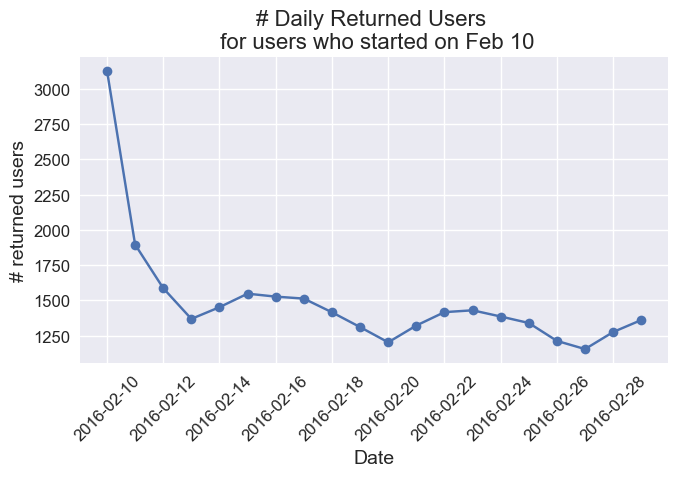

In [23]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
mpl.rcParams['font.size'] = 14.; mpl.rc('xtick', labelsize=12); mpl.rc('ytick', labelsize=12) 

plt.plot_date(*zip(*sorted(returned_user_10.items())), 'o-')
plt.xlabel('Date', fontsize=14); plt.ylabel('# returned users', fontsize=14)
plt.title('# Daily Returned Users \n for users who started on Feb 10', fontsize=16)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
   
plt.tight_layout()
plt.show()

In [24]:
df_14 = df_s[(df_s.date == '2016-02-14') & (df_s.isFirst == True)].reset_index()
print('There are',len(df_14.uid), 'new users on', df_14.date.loc[0])
users_14 = df_14.uid.tolist()

There are 2761 new users on 2016-02-14 00:00:00


In [25]:
returned_user_14 = {}
for i in range(len(dates)):
    df_date = df_s[df_s.date == dates[i]]
    df_date.sort_index(by='date', ascending=False, inplace=True)
    if df_date.date.iloc[0] >= df_14.date.iloc[0]:
        print(df_date.date.iloc[0], 'is a later date than', df_14.date.iloc[0])
        n_users = len(df_date[df_date['uid'].isin(users_14)]['uid'].unique())
        returned_user_14[df_date.date.iloc[0]] = n_users

print('From the', len(users_14), returned_user_14, 'return each day')

/Applications/Anaconda-/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  after removing the cwd from sys.path.
/Applications/Anaconda-/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inplace=inplace)


2016-02-14 00:00:00 is a later date than 2016-02-14 00:00:00
2016-02-15 00:00:00 is a later date than 2016-02-14 00:00:00
2016-02-16 00:00:00 is a later date than 2016-02-14 00:00:00
2016-02-17 00:00:00 is a later date than 2016-02-14 00:00:00
2016-02-18 00:00:00 is a later date than 2016-02-14 00:00:00
2016-02-19 00:00:00 is a later date than 2016-02-14 00:00:00
2016-02-20 00:00:00 is a later date than 2016-02-14 00:00:00
2016-02-21 00:00:00 is a later date than 2016-02-14 00:00:00
2016-02-22 00:00:00 is a later date than 2016-02-14 00:00:00
2016-02-23 00:00:00 is a later date than 2016-02-14 00:00:00
2016-02-24 00:00:00 is a later date than 2016-02-14 00:00:00
2016-02-25 00:00:00 is a later date than 2016-02-14 00:00:00
2016-02-26 00:00:00 is a later date than 2016-02-14 00:00:00
2016-02-27 00:00:00 is a later date than 2016-02-14 00:00:00
2016-02-28 00:00:00 is a later date than 2016-02-14 00:00:00
2016-02-29 00:00:00 is a later date than 2016-02-14 00:00:00
From the 2761 {Timestamp

In [26]:
returned_user_14_norm = {}
for key, value in returned_user_14.items():
    returned_user_14_norm[key] = value / len(users_04)

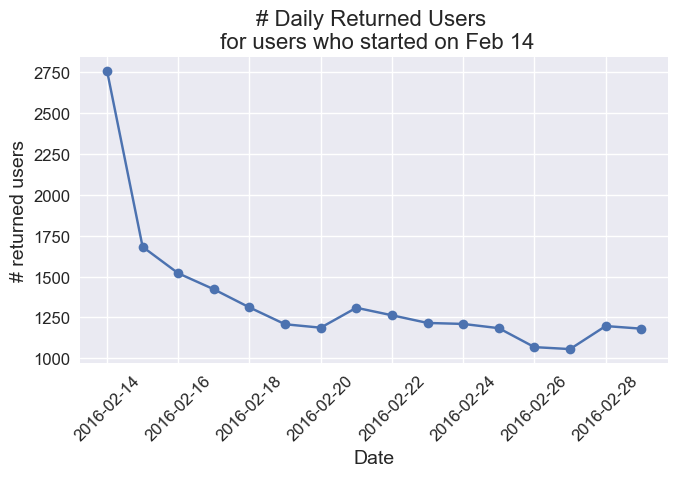

In [27]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
mpl.rcParams['font.size'] = 14.; mpl.rc('xtick', labelsize=12); mpl.rc('ytick', labelsize=12) 

plt.plot_date(*zip(*sorted(returned_user_14.items())), 'o-')
plt.xlabel('Date', fontsize=14); plt.ylabel('# returned users', fontsize=14)
plt.title('# Daily Returned Users \n for users who started on Feb 14', fontsize=16)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
   
plt.tight_layout()
plt.show()

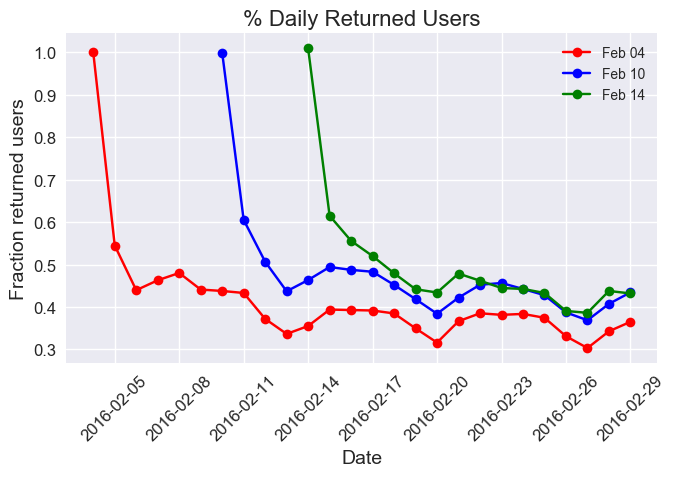

In [28]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
mpl.rcParams['font.size'] = 14.; mpl.rc('xtick', labelsize=12); mpl.rc('ytick', labelsize=12) 

plt.plot_date(*zip(*sorted(returned_user_04_norm.items())), 'o-', color='r')
plt.plot_date(*zip(*sorted(returned_user_10_norm.items())), 'o-', color='b')
plt.plot_date(*zip(*sorted(returned_user_14_norm.items())), 'o-', color='g')
plt.xlabel('Date', fontsize=14); plt.ylabel('Fraction returned users', fontsize=14)
plt.legend(['Feb 04', 'Feb 10', 'Feb 14'], loc='best')
plt.title('% Daily Returned Users', fontsize=16)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
   
plt.tight_layout()
#plt.savefig('./figs/fraction_returned_users_three_days.png', bbox_inches='tight')
plt.show(fig)

plt.close()

In [29]:
print('Day of the week for', list(returned_user_04_norm.keys())[0], 'is:', 
      list(returned_user_04_norm.keys())[0].weekday()) #Thursday
print('Day of the week for', list(returned_user_10_norm.keys())[0], 'is:', 
      list(returned_user_10_norm.keys())[0].weekday()) #Wednesday
print('Day of the week for', list(returned_user_14_norm.keys())[0], 'is:', 
      list(returned_user_14_norm.keys())[0].weekday()) #Sunday

Day of the week for 2016-02-04 00:00:00 is: 3
Day of the week for 2016-02-10 00:00:00 is: 2
Day of the week for 2016-02-14 00:00:00 is: 6


We can still see the weekly trend

In [30]:
print('Percentage of users on Feb 5:', "{:.3f}".format(list(returned_user_04_norm.values())[1]))
print('Percentage of users on Feb 11:', "{:.3f}".format(list(returned_user_10_norm.values())[1]))
print('Percentage of users on Feb 15:', "{:.3f}".format(list(returned_user_14_norm.values())[1]))

Percentage of users on Feb 5: 0.545
Percentage of users on Feb 11: 0.605
Percentage of users on Feb 15: 0.615


On the second day, the number of users has decreased to 54% for users who started using the app on Feb-04 and to 61% for users who started using the app on Feb-10 and Feb-14.

## Q3: Determine if there are any differences in usage based on where the users came from. From which traffic source does the app get its best users? Its worst users?

In [31]:
source = df.utmSource.unique()
print('There are', len(source), 'different traffic sources from which the user came')

There are 53 different traffic sources from which the user came


In [32]:
## Group by "source"
freq_sources = df_s.groupby('utmSource')['uid'].count().reset_index()
freq_sources.sort_values(by='uid', ascending=False, inplace=True)

labels = freq_sources['utmSource'].values
y_pos = np.arange(len(labels))
percentage_sources = freq_sources['uid'].values/freq_sources['uid'].sum()

print('The different traffic sources are:')
print(labels)

The different traffic sources are:
['Biznesowe+Rewolucje' 'program' 'answers' 'shmoop_left' 'twitter'
 'MosaLingua+FR' 'other' 'Grub+Street' 'salesmanago' 'handbook' 'youtube'
 'Just-In-Time+Travels+Newsletter' 'tapjoy' 'contenthub' 'dict' 'placement'
 'Facebook_org' 'blog' 'liveintent' 'facebook' 'google'
 'Wise+Ink+Master+Email+List' 'Blog_org' 'TrialIntro'
 'MembershipCancellation' 'nettedbythewebbys' 'email-sendgrid'
 'facebook.com' 'Bing' 'outbrain' 'Pre-quote+List' 'SummerInvite'
 "Sarah+Doody's+UX+Notebook" 'pandora' 'bing' 'digg' 'Book+Quote'
 'GPlus_org' 're:+charity' 'Twitter_org' 'sendgrid.com' 'cafemom.com'
 'shmoop_right' 'LinkedIn_org' 'shmoop_logo' 'brand'
 'Sticky Blogging Secrets' 'blogger_outreach' 'taboola' 'gsp' 'card'
 'display']


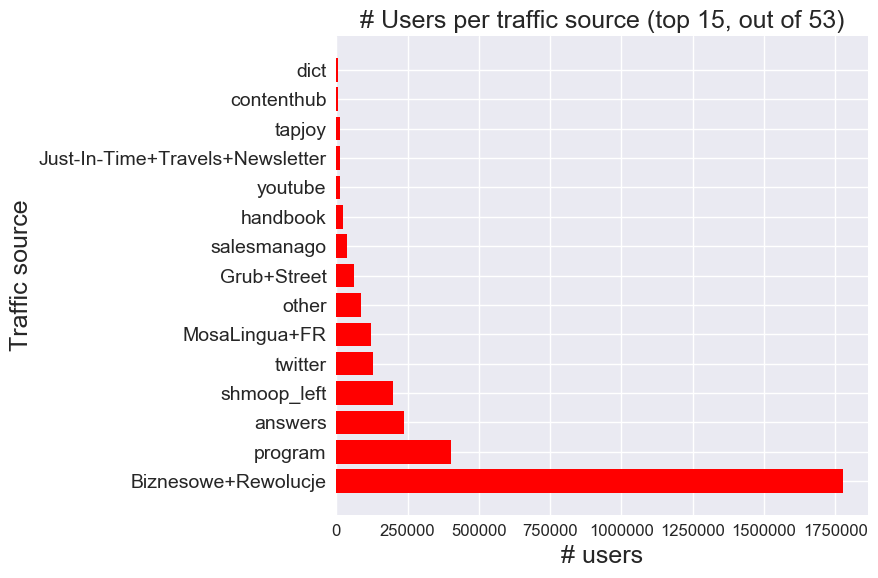

array([ 56.53665718,  12.86156443,   7.56689344,   6.30132644,
         4.05561252,   3.91148637,   2.80757997,   1.93703129,
         1.19759317,   0.70494204,   0.43489247,   0.36707776,
         0.36558208,   0.22467004,   0.20417606])

In [33]:
plt.clf()
fig = plt.figure(figsize=(9,6))

plt.barh(y_pos[0:15], freq_sources['uid'][0:15], align='center', color='red')
plt.title('# Users per traffic source (top 15, out of 53)', fontsize=18)
plt.xlabel('# users', fontsize=18)
plt.ylabel('Traffic source', fontsize=18)
plt.yticks(y_pos[0:15], labels[0:15], fontsize=14)
plt.tight_layout()
plt.show(fig)
#plt.savefig('./figs/source_fraction.png', bbox_inches='tight')
plt.close('all')

percentage_sources[0:15]*100

In [34]:
print('The top source is', labels[0], 'with', "{:.1f}".format(percentage_sources[0]*100), 
      '% and the less frequent source is', labels[-1], 'with', "{:.4f}".format(percentage_sources[-1]*100), '%')

The top source is Biznesowe+Rewolucje with 56.5 % and the less frequent source is display with 0.0002 %


In [35]:
source1 = df_s[df_s.utmSource == 'Biznesowe+Rewolucje'].drop_duplicates().groupby('date').count().dropna().reset_index()
source2 = df_s[df_s.utmSource == 'program'].drop_duplicates().groupby('date').count().dropna().reset_index()
source3 = df_s[df_s.utmSource == 'display'].drop_duplicates().groupby('date').count().dropna().reset_index()
source4 = df_s[df_s.utmSource == 'card'].drop_duplicates().groupby('date').count().dropna().reset_index()
source5 = df_s[df_s.utmSource == labels[2]].drop_duplicates().groupby('date').count().dropna().reset_index()
#labels[2]

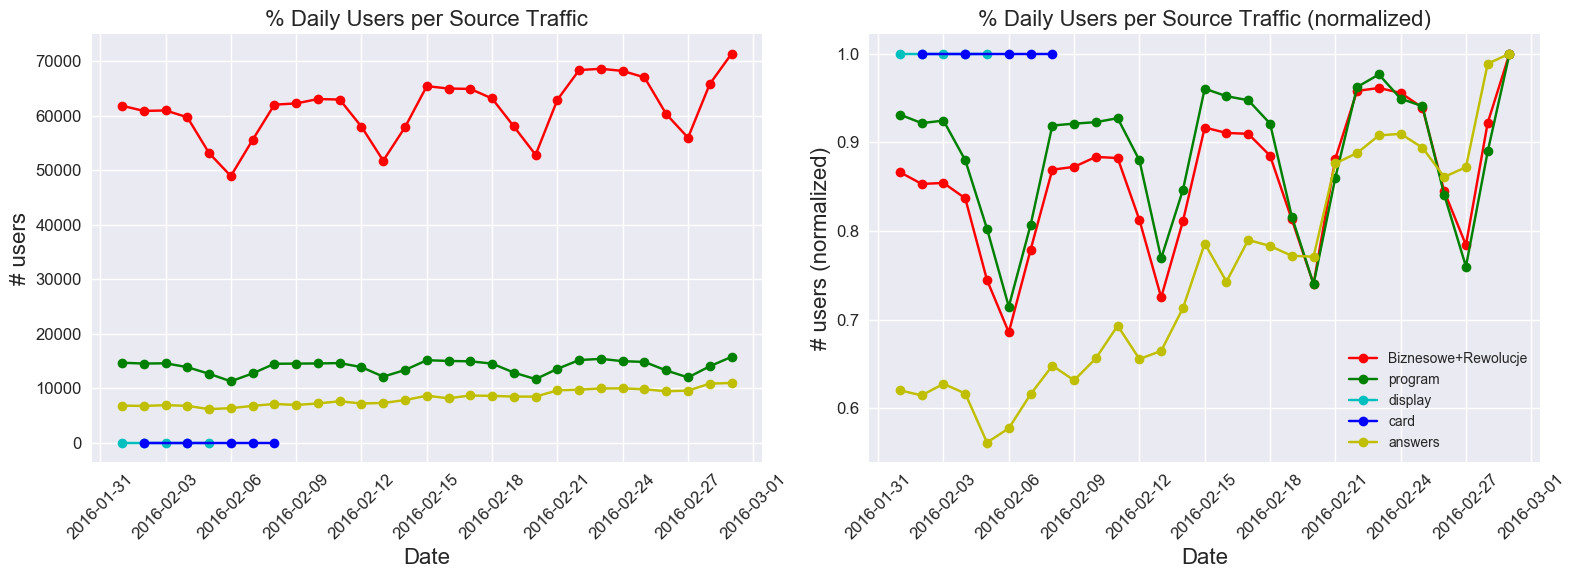

In [36]:
plt.clf()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))

cc = ['r','g','c','b', 'y']

ax1.plot_date(source1.date, source1.uid, 'o-', color=cc[0])
ax1.plot_date(source2.date, source2.uid, 'o-', color=cc[1])
ax1.plot_date(source3.date, source3.uid, 'o-', color=cc[2])
ax1.plot_date(source4.date, source4.uid, 'o-', color=cc[3])
ax1.plot_date(source5.date, source5.uid, 'o-', color=cc[4])
ax1.set_xlabel('Date', fontsize=16); ax1.set_ylabel('# users', fontsize=16)
ax1.set_title('% Daily Users per Source Traffic', fontsize=16)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

ax2.plot_date(source1.date, source1.uid/source1.uid.max(), 'o-', color=cc[0])
ax2.plot_date(source2.date, source2.uid/source2.uid.max(), 'o-', color=cc[1])
ax2.plot_date(source3.date, source3.uid/source3.uid.max(), 'o-', color=cc[2])
ax2.plot_date(source4.date, source4.uid/source4.uid.max(), 'o-', color=cc[3])
ax2.plot_date(source5.date, source5.uid/source5.uid.max(), 'o-', color=cc[4])
ax2.set_xlabel('Date', fontsize=16); ax2.set_ylabel('# users (normalized)', fontsize=16)
ax2.set_title('% Daily Users per Source Traffic (normalized)', fontsize=16)
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
   
plt.legend(['Biznesowe+Rewolucje','program','display','card','answers'], loc='best')
plt.tight_layout()
plt.show(fig)
#plt.savefig('./figs/users_source_time.png', bbox_inches='tight')

plt.close()

The top two sources (“Biznesowe+Rewolucje” (red), “program” (green)) show the previously described weekly pattern. The bottom two sources (“card” (blue) and “display” (cyan)) have very few users, but they are constant over time, although only for a few days. The third most common traffic source (“answers” (yellow)) quickly increases over time along the whole month and the weekly variations are smoother than in the previous examples (red and green).